# Vision-nanoGPT:

### Advanced Implementation with Interactive Visualizations
### Vision-NanoGPT


### 1. Setting Up the Environment


In [1]:
import os
import math
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import random
from IPython.display import display, HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set plotting style
sns.set_context("notebook", font_scale=1.2)

Using device: cuda


## 2. Creating Custom Dataset and Data Visualization
use a combination of MNIST and FashionMNIST, but with enhanced visualization and analysis.

In [2]:
class CombinedMNISTDataset(Dataset):
    """
    Dataset that combines MNIST and FashionMNIST datasets with
    additional metadata tracking.
    """

    def __init__(self, root='./data', train=True, transform=None, download=True):
        self.transform = transform
        self.train = train

        # Get MNIST
        mnist = datasets.MNIST(root=root, train=train, download=download, transform=None)

        # Get FashionMNIST
        fashion_mnist = datasets.FashionMNIST(root=root, train=train, download=download, transform=None)

        # Convert data to appropriate format
        mnist_data = mnist.data.unsqueeze(1).float() / 255.0
        fashion_data = fashion_mnist.data.unsqueeze(1).float() / 255.0

        # Combine data
        self.data = torch.cat([mnist_data, fashion_data])

        # Combine targets, shifting FashionMNIST by 10
        self.targets = torch.cat([
            mnist.targets,
            fashion_mnist.targets + 10
        ])

        # Track origins for analysis
        self.origins = torch.cat([
            torch.zeros_like(mnist.targets),  # 0 for MNIST
            torch.ones_like(fashion_mnist.targets)  # 1 for FashionMNIST
        ])

        # Define class names and groups
        self.class_names = [
            # MNIST (0-9)
            '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
            # FashionMNIST (10-19)
            'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
            'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
        ]

        self.class_groups = {
            'MNIST Digits': list(range(10)),
            'Fashion (Clothing)': [10, 11, 12, 13, 14, 16],
            'Fashion (Footwear)': [15, 17, 19],
            'Fashion (Accessories)': [18]
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, target = self.data[idx], int(self.targets[idx])
        origin = int(self.origins[idx])

        # Apply transforms if specified
        if self.transform is not None:
            img = self.transform(img)

        # Return image, target and origin
        return img, target, origin

    def get_stats(self):
        """Get dataset statistics"""
        stats = {
            'total_samples': len(self.data),
            'mnist_samples': (self.origins == 0).sum().item(),
            'fashion_samples': (self.origins == 1).sum().item(),
            'class_distribution': []
        }

        for i in range(20):
            count = (self.targets == i).sum().item()
            stats['class_distribution'].append({
                'class_id': i,
                'class_name': self.class_names[i],
                'count': count,
                'percentage': count / len(self.data) * 100
            })

        return stats

In [3]:
def get_advanced_transforms():
    """Create advanced data transformations"""
    # Base transformations
    normalize = transforms.Normalize((0.5,), (0.5,))

    # Training transformations with more augmentation
    train_transform = transforms.Compose([
        transforms.RandomRotation(10),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
        transforms.RandomErasing(p=0.2, scale=(0.02, 0.1)),
        normalize
    ])

    # Validation transformations
    val_transform = transforms.Compose([
        normalize
    ])

    return train_transform, val_transform

# Create datasets with our advanced transforms
train_transform, val_transform = get_advanced_transforms()

train_dataset = CombinedMNISTDataset(
    root='./data',
    train=True,
    transform=train_transform,
    download=True
)

val_dataset = CombinedMNISTDataset(
    root='./data',
    train=False,
    transform=val_transform,
    download=True
)

# Create dataloaders
batch_size = 64
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

class_names = train_dataset.class_names

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.10MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.97MB/s]
100%|██████████| 26.4M/26.4M [00:02<00:00, 10.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 171kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.21MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.98MB/s]


## 3. Interactive Data Exploration
ccreeate some interactive visualizations to explore our dataset:

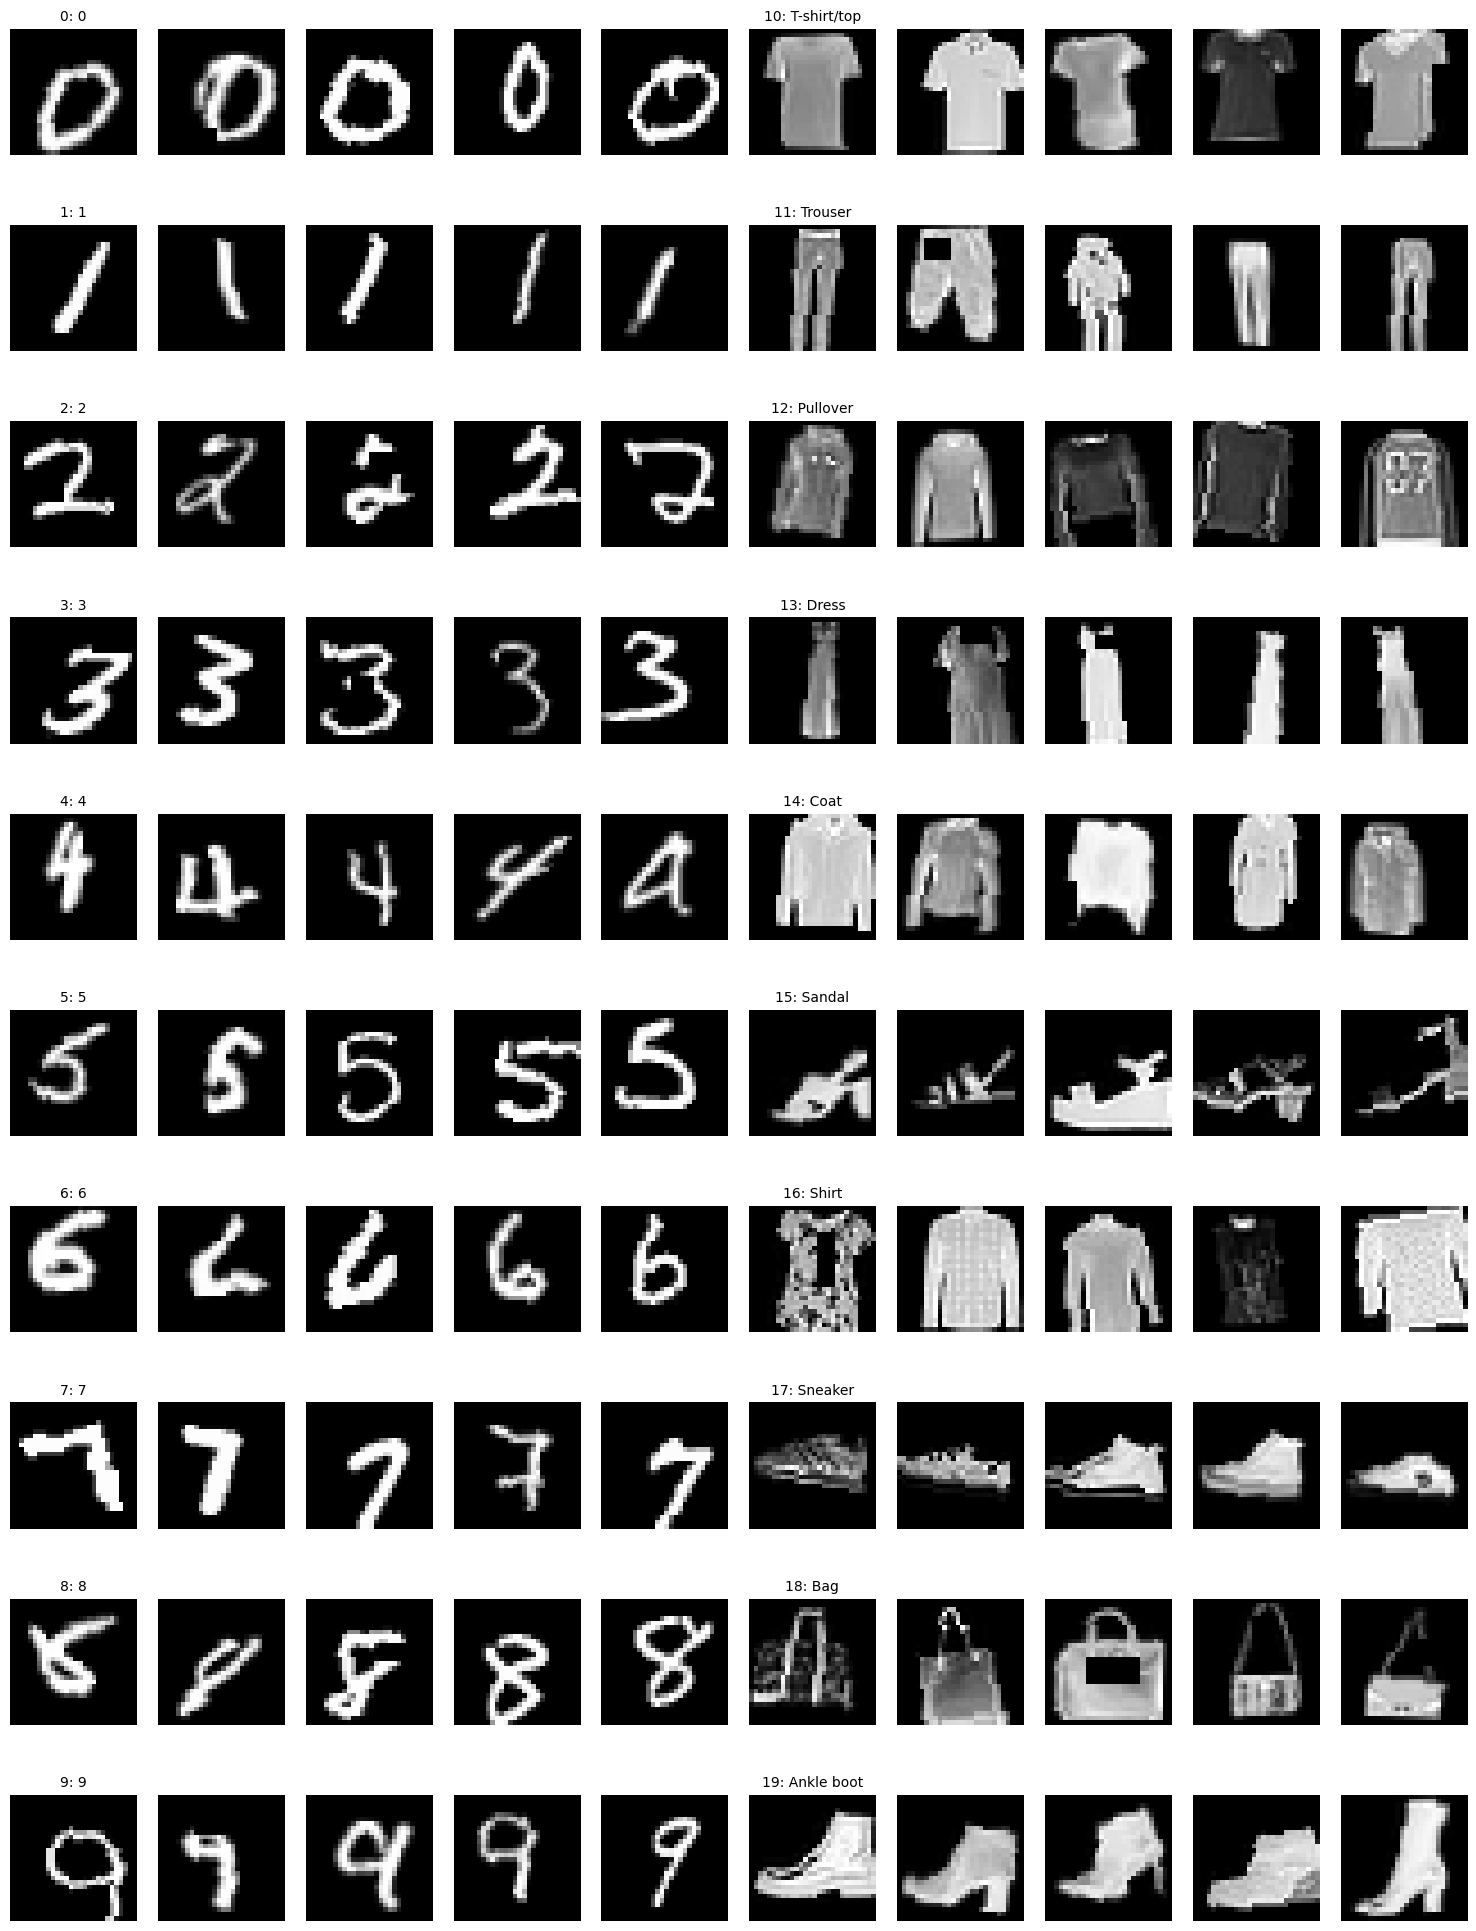

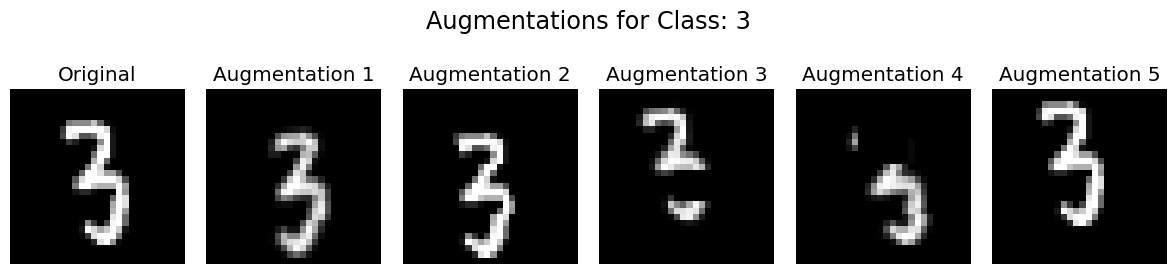

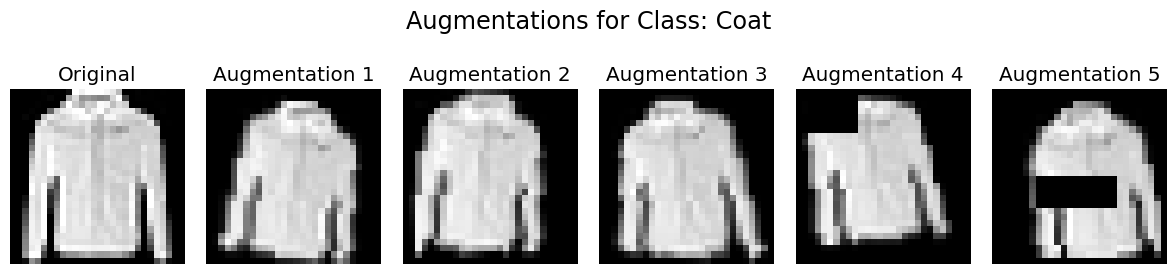

In [4]:
# Get dataset statistics
train_stats = train_dataset.get_stats()
val_stats = val_dataset.get_stats()

# Create a DataFrame for better analysis
train_df = pd.DataFrame(train_stats['class_distribution'])
val_df = pd.DataFrame(val_stats['class_distribution'])

# Add a 'split' column
train_df['split'] = 'Train'
val_df['split'] = 'Validation'

# Combine the DataFrames
all_df = pd.concat([train_df, val_df], ignore_index=True)

# Create a dataset origin column
all_df['origin'] = ['MNIST' if i < 10 else 'FashionMNIST' for i in all_df['class_id']]

# Create an interactive bar chart with Plotly
fig = px.bar(
    all_df,
    x='class_name',
    y='count',
    color='origin',
    facet_col='split',
    title='Class Distribution in Train and Validation Sets',
    labels={'class_name': 'Class', 'count': 'Number of Samples', 'origin': 'Dataset Origin'},
    height=500
)

fig.update_layout(xaxis_tickangle=-45)
fig.show()

# Create a function to display random examples from each class
def plot_class_examples(dataset, num_examples=5, figsize=(15, 20)):
    fig, axes = plt.subplots(nrows=10, ncols=2*num_examples, figsize=figsize)

    for i in range(20):
        # Find all indices where the target is equal to i
        indices = (dataset.targets == i).nonzero().flatten().tolist()

        # Sample num_examples random indices
        if len(indices) >= num_examples:
            sampled_indices = random.sample(indices, num_examples)
        else:
            sampled_indices = indices

        for j, idx in enumerate(sampled_indices):
            img, target, _ = dataset[idx]

            # Calculate the position in the subplot grid
            row = i % 10
            col = (i // 10) * num_examples + j

            axes[row, col].imshow(img.squeeze(), cmap='gray')
            axes[row, col].axis('off')

            if j == 0:
                axes[row, col].set_title(f"{i}: {dataset.class_names[i]}", fontsize=10)

    plt.tight_layout()
    plt.show()

# Display examples from each class
plot_class_examples(train_dataset)

# Visualize data augmentation effects
def show_augmentations(dataset, class_idx=1, num_augmentations=5):
    """Show multiple augmentations of the same image"""
    # Find an example of the selected class
    indices = (dataset.targets == class_idx).nonzero().flatten().tolist()
    idx = random.choice(indices)

    # Get the original image
    original_img = dataset.data[idx].squeeze()

    # Create a figure to display the original and augmented images
    fig, axes = plt.subplots(1, num_augmentations + 1, figsize=(12, 3))

    # Display the original image
    axes[0].imshow(original_img, cmap='gray')
    axes[0].set_title('Original')
    axes[0].axis('off')

    # Apply transformations and display augmented images
    for i in range(1, num_augmentations + 1):
        # Apply transform to a copy of the original image
        img_tensor = dataset.data[idx].clone()
        img_tensor = train_transform(img_tensor)

        # Display the augmented image
        axes[i].imshow(img_tensor.squeeze(), cmap='gray')
        axes[i].set_title(f'Augmentation {i}')
        axes[i].axis('off')

    plt.suptitle(f'Augmentations for Class: {class_names[class_idx]}')
    plt.tight_layout()
    plt.show()

# Show augmentations for a digit and a fashion item
show_augmentations(train_dataset, class_idx=3)  # Digit 3
show_augmentations(train_dataset, class_idx=14)  # Coat

## 4. Advanced Model Architecture with Residual Connection

implement an enhanced version of Vision-nanoGPT with residual connections, layer scaling, and other advanced features:

In [6]:
class LayerNorm(nn.Module):
    """LayerNorm with optional bias"""
    def __init__(self, ndim, bias=True):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

class PatchEmbedding(nn.Module):
    """Enhanced patch embedding with positional encoding"""
    def __init__(self, img_size=28, patch_size=4, in_channels=1, embed_dim=256):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        # Learnable patch embedding projection
        self.proj = nn.Conv2d(
            in_channels,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

        # CLS token for classification
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        # Learnable positional embedding
        self.pos_embed = nn.Parameter(torch.zeros(1, self.n_patches + 1, embed_dim))

        # Initialize with sinusoidal encoding
        self._init_pos_embedding()

        # Patch dropout (for regularization)
        self.patch_dropout = nn.Dropout(0.1)

    def _init_pos_embedding(self):
        """Initialize positional embedding with sinusoidal pattern"""
        position = torch.arange(self.n_patches + 1).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.pos_embed.size(-1), 2) *
                            -(math.log(10000.0) / self.pos_embed.size(-1)))

        pe = torch.zeros_like(self.pos_embed)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)

        # Exclude CLS token from sinusoidal pattern
        pe[0, 0, :] = 0

        with torch.no_grad():
            self.pos_embed.copy_(pe)

    def forward(self, x):
        B = x.shape[0]

        # Extract patches
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)

        # Apply patch dropout during training
        if self.training:
            x = self.patch_dropout(x)

        # Add CLS token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # Add positional embedding
        x = x + self.pos_embed

        return x

class MultiHeadAttention(nn.Module):
    """Advanced multi-head attention with residual connections"""
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0

        # Attention projections
        self.qkv = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)

        # Output projection
        self.out_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.out_dropout = nn.Dropout(config.dropout)

        # Dimensions
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.head_dim = config.n_embd // config.n_head

        # Scaling factor
        self.scale = self.head_dim ** -0.5

        # Layer scale
        # self.layer_scale = config.get('layer_scale', None)
        self.layer_scale = getattr(config, 'layer_scale', None)
        if self.layer_scale is not None:
            self.gamma = nn.Parameter(self.layer_scale * torch.ones(config.n_embd))

        # Flash attention if available
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')

        # Save attention maps for visualization
        self.save_attention = False
        self.attention_maps = None

    def forward(self, x):
        B, N, C = x.shape

        # QKV projection
        qkv = self.qkv(x).reshape(B, N, 3, self.n_head, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # [B, n_head, N, head_dim]

        # Scaled dot-product attention
        if self.flash:
            # Use flash attention
            attn_output = F.scaled_dot_product_attention(
                q, k, v,
                dropout_p=self.attn_dropout.p if self.training else 0.0,
                is_causal=False
            )
        else:
            # Manual implementation
            attn = (q @ k.transpose(-2, -1)) * self.scale
            attn = F.softmax(attn, dim=-1)

            # Save attention maps if requested
            if self.save_attention:
                self.attention_maps = attn.detach().cpu()

            attn = self.attn_dropout(attn)
            attn_output = attn @ v

        # Reshape and project output
        x = attn_output.transpose(1, 2).reshape(B, N, C)
        x = self.out_proj(x)

        # Apply layer scaling if enabled
        if self.layer_scale is not None:
            x = self.gamma * x

        x = self.out_dropout(x)

        return x

class FeedForward(nn.Module):
    """Enhanced feed-forward network with GELU activation and residual connections"""
    def __init__(self, config):
        super().__init__()
        self.fc1 = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

        # Layer scale
        # self.layer_scale = config.get('layer_scale', None)
        self.layer_scale = getattr(config, 'layer_scale', None)
        if self.layer_scale is not None:
            self.gamma = nn.Parameter(self.layer_scale * torch.ones(config.n_embd))

    def forward(self, x):
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.fc2(x)

        # Apply layer scaling if enabled
        if self.layer_scale is not None:
            x = self.gamma * x

        x = self.dropout(x)
        return x

class TransformerBlock(nn.Module):
    """Enhanced transformer block with pre-norm architecture"""
    def __init__(self, config):
        super().__init__()
        self.ln1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = MultiHeadAttention(config)
        self.ln2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = FeedForward(config)

        # Skip connection scaling factor (for improved training)
        # self.skip_scale = config.get('skip_scale', 1.0)
        self.skip_scale = getattr(config, 'skip_scale', 1.0)

    def forward(self, x):
        # Pre-norm architecture with scaled skip connections
        x = x + self.skip_scale * self.attn(self.ln1(x))
        x = x + self.skip_scale * self.mlp(self.ln2(x))
        return x

class AdvancedVisionGPTConfig:
    """Configuration for the Advanced VisionGPT model"""
    def __init__(self, **kwargs):
        # Vision parameters
        self.img_size = 28
        self.patch_size = 4
        self.in_channels = 1
        self.n_classes = 20

        # Model parameters
        self.n_layer = 8
        self.n_head = 8
        self.n_embd = 256
        self.dropout = 0.1
        self.bias = True

        # Advanced parameters
        self.layer_scale = 1e-4  # For better training of deeper networks
        self.skip_scale = 0.5   # Scale skip connections
        self.stochastic_depth = 0.1  # Stochastic depth probability
        self.embed_dropout = 0.1  # Dropout rate after patch embedding

        # Calculate block_size
        self.block_size = (self.img_size // self.patch_size) ** 2 + 1  # +1 for cls token

        # Override defaults with kwargs
        for k, v in kwargs.items():
            setattr(self, k, v)

class AdvancedVisionGPT(nn.Module):
    """
    Advanced VisionGPT with improved architecture and visualization capabilities.
    """
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Patch embedding
        self.patch_embed = PatchEmbedding(
            img_size=config.img_size,
            patch_size=config.patch_size,
            in_channels=config.in_channels,
            embed_dim=config.n_embd
        )

        # Dropout after embedding
        self.embed_dropout = nn.Dropout(config.embed_dropout)

        # Transformer blocks with stochastic depth
        self.blocks = nn.ModuleList([
            TransformerBlock(config) for _ in range(config.n_layer)
        ])

        # Stochastic depth probabilities
        if config.stochastic_depth > 0:
            dpr = [x.item() for x in torch.linspace(0, config.stochastic_depth, config.n_layer)]
            self.dpr = dpr
        else:
            self.dpr = [0] * config.n_layer

        # Final layernorm
        self.ln_f = LayerNorm(config.n_embd, bias=config.bias)

        # Classification head
        self.head = nn.Linear(config.n_embd, config.n_classes, bias=False)

        # Initialize weights
        self.apply(self._init_weights)

        # Special scaled init for projections
        for pn, p in self.named_parameters():
            if pn.endswith('out_proj.weight') or pn.endswith('fc2.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # Store embeddings for visualization
        self.cls_embeddings = None

        # Print parameter count
        print(f"Number of parameters: {self.get_num_params()/1e6:.2f}M")

    def get_num_params(self):
        """Return the number of parameters in the model"""
        return sum(p.numel() for p in self.parameters())

    def _init_weights(self, module):
        """Initialize weights with improved scheme"""
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.ones_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)

    def forward_features(self, x):
        """Forward pass up to the feature level (before classification head)"""
        # Patch embedding
        x = self.patch_embed(x)

        # Apply embedding dropout
        x = self.embed_dropout(x)

        # Store input embeddings for visualization
        if not self.training:
            self.input_embeddings = x.detach().clone()

        # Apply transformer blocks with stochastic depth
        for i, block in enumerate(self.blocks):
            if self.training and torch.rand(1).item() < self.dpr[i]:
                # Skip this block (stochastic depth)
                continue

            # Set attention saving for the last block if not training
            if not self.training and i == len(self.blocks) - 1:
                block.attn.save_attention = True
            else:
                block.attn.save_attention = False

            x = block(x)

        # Apply final normalization
        x = self.ln_f(x)

        # Store CLS token embeddings for visualization
        if not self.training:
            self.cls_embeddings = x[:, 0].detach().clone()

        return x

    def forward(self, x, targets=None):
        """Forward pass with optional loss calculation"""
        # Get features
        x = self.forward_features(x)

        # Use CLS token for classification
        logits = self.head(x[:, 0])

        # Calculate loss if targets are provided
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def get_attention_maps(self):
        """Get attention maps from the last block"""
        if hasattr(self.blocks[-1].attn, 'attention_maps'):
            return self.blocks[-1].attn.attention_maps
        return None

# Create the model
model_config = AdvancedVisionGPTConfig(
    img_size=28,
    patch_size=4,
    in_channels=1,
    n_layer=8,
    n_head=8,
    n_embd=256,
    dropout=0.1,
    bias=True,
    layer_scale=1e-4,
    skip_scale=0.5,
    stochastic_depth=0.1,
    n_classes=20
)

model = AdvancedVisionGPT(model_config).to(device)

Number of parameters: 6.35M


## 5. Advanced Training and Visualization Tools
create an advanced training pipeline with learning rate finder, mixed precision training, and more detailed monitoring:

In [11]:
# Advanced optimizer configuration
def configure_optimizer(model, weight_decay=0.05, learning_rate=1e-3, betas=(0.9, 0.999), eps=1e-8):
    """Configure optimizer with parameter-specific settings"""
    # Separate parameters for different weight decay
    decay_params = []
    nodecay_params = []

    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue

        # Apply weight decay to weights but not to biases, layer norms and embeddings
        if len(param.shape) <= 1 or 'ln' in name or 'bias' in name or 'pos_embed' in name or 'cls_token' in name:
            nodecay_params.append(param)
        else:
            decay_params.append(param)

    optim_groups = [
        {"params": decay_params, "weight_decay": weight_decay},
        {"params": nodecay_params, "weight_decay": 0.0},
    ]

    print(f"Decay parameters: {len(decay_params)}, Non-decay parameters: {len(nodecay_params)}")

    # Create AdamW optimizer
    optimizer = torch.optim.AdamW(
        optim_groups,
        lr=learning_rate,
        betas=betas,
        eps=eps
    )

    return optimizer

# Learning rate finder
def find_learning_rate(model, train_loader, optimizer, device, start_lr=1e-7, end_lr=1, num_iter=100):
    """Find optimal learning rate using exponential scheduling"""
    # Save original model and optimizer state
    model_state = {k: v.clone() for k, v in model.state_dict().items()}
    optimizer_state = optimizer.state_dict()

    # Prepare for LR finder
    model.train()
    lrs = []
    losses = []

    # Set initial learning rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = start_lr

    # Calculate LR multiplier
    mult = (end_lr / start_lr) ** (1 / num_iter)

    # LR finder loop
    for i, (images, targets, _) in enumerate(train_loader):
        if i >= num_iter:
            break

        images, targets = images.to(device), targets.to(device)

        # Forward pass
        optimizer.zero_grad()
        logits, loss = model(images, targets)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Log learning rate and loss
        lr = optimizer.param_groups[0]['lr']
        lrs.append(lr)
        losses.append(loss.item())

        # Update learning rate
        for param_group in optimizer.param_groups:
            param_group['lr'] *= mult

        if i % 10 == 0:
            print(f"Iteration {i}: lr={lr:.8f}, loss={loss.item():.4f}")

    # Restore original model and optimizer state
    model.load_state_dict(model_state)
    optimizer.load_state_dict(optimizer_state)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.semilogx(lrs, losses)
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.title('Learning Rate Finder')
    plt.grid(True, which="both")
    plt.axvline(x=lrs[np.argmin(losses)], color='r', linestyle='--')
    plt.text(lrs[np.argmin(losses)], min(losses), f"Best LR: {lrs[np.argmin(losses)]:.6f}")
    plt.show()

    return lrs[np.argmin(losses)]

# Advanced learning rate scheduler with warm-up and cosine decay
class CosineWarmupScheduler:
    def __init__(self, optimizer, warmup_epochs, max_epochs, min_lr_ratio=0.1,
                 warmup_start_lr_ratio=0.01):

        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.max_epochs = max_epochs
        self.min_lr_ratio = min_lr_ratio
        self.warmup_start_lr_ratio = warmup_start_lr_ratio

        # Get base learning rates for each param group
        self.base_lrs = [group['lr'] for group in optimizer.param_groups]

        # Initialize epoch counter
        self.epoch = 0

    def step(self):
      """Update learning rate based on current epoch"""
      if self.epoch < self.warmup_epochs:
          # Linear warmup
          alpha = self.epoch / self.warmup_epochs
          lr_factor = self.warmup_start_lr_ratio + (1 - self.warmup_start_lr_ratio) * alpha
      else:
          # Cosine decay
          progress = (self.epoch - self.warmup_epochs) / (self.max_epochs - self.warmup_epochs)
          progress = min(1.0, progress)
          lr_factor = self.min_lr_ratio + 0.5 * (1 - self.min_lr_ratio) * (1 + math.cos(math.pi * progress))

      # Update learning rate for each parameter group
      for param_group, base_lr in zip(self.optimizer.param_groups, self.base_lrs):
          param_group['lr'] = base_lr * lr_factor

      # Increment epoch counter
      self.epoch += 1

    def get_lr(self):
      """Get current learning rate"""
      return [group['lr'] for group in self.optimizer.param_groups]

## advanced training functions with mixed precision:

In [19]:
# Set up optimizer and learning rate scheduler
weight_decay = 0.05
learning_rate = 1e-3
betas = (0.9, 0.999)
eps = 1e-8
is_cuda = device.type == 'cuda'
optimizer = configure_optimizer(
    model,
    weight_decay=weight_decay,
    learning_rate=learning_rate,
    betas=betas,
    eps=eps
)

# Optional: Find optimal learning rate
# best_lr = find_learning_rate(model, train_loader, optimizer, device)
# print(f"Best learning rate found: {best_lr:.6f}")
#
# # Update optimizer with best learning rate
# for param_group in optimizer.param_groups:
#     param_group['lr'] = best_lr

# Set up scheduler
epochs = 10
warmup_epochs = 1
scheduler = CosineWarmupScheduler(
    optimizer,
    warmup_epochs=warmup_epochs,
    max_epochs=epochs,
    min_lr_ratio=0.05,
    warmup_start_lr_ratio=0.01
)

# Training and evaluation functions with mixed precision
from torch.cuda.amp import autocast, GradScaler

def evaluate(model, dataloader, device, num_batches=None):
    """Evaluate model with mixed precision"""
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_targets = []
    all_origins = []

    batches = dataloader
    if num_batches is not None:
        # Take only a subset of batches
        batches = list(islice(iter(dataloader), num_batches))

    with torch.no_grad():
        for batch in batches:
            images, targets, origins = batch
            images = images.to(device)
            targets = targets.to(device)

            with torch.amp.autocast(device_type=device.type, enabled=is_cuda):
              logits, loss = model(images, targets)

            preds = torch.argmax(logits, dim=-1)

            # Track metrics
            total_loss += loss.item() * len(targets)
            total_correct += (preds == targets).sum().item()
            total_samples += len(targets)

            # Store predictions and targets for analysis
            all_preds.append(preds.cpu())
            all_targets.append(targets.cpu())
            all_origins.append(origins)

    # Compute metrics
    avg_loss = total_loss / total_samples
    accuracy = 100 * total_correct / total_samples

    # Combine predictions and targets
    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()
    all_origins = torch.cat(all_origins).numpy()

    # Additional metrics
    metrics = {
        'loss': avg_loss,
        'accuracy': accuracy,
        'predictions': all_preds,
        'targets': all_targets,
        'origins': all_origins,

        # Compute accuracy for MNIST vs FashionMNIST
        'mnist_accuracy': 100 * np.sum((all_preds == all_targets) & (all_origins == 0)) / np.sum(all_origins == 0),
        'fashion_accuracy': 100 * np.sum((all_preds == all_targets) & (all_origins == 1)) / np.sum(all_origins == 1)
    }

    return metrics

def train_epoch(model, dataloader, optimizer, device, scaler, epoch):
    """Train for one epoch with mixed precision"""
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    pbar = tqdm(dataloader, leave=False)
    for i, (images, targets, _) in enumerate(pbar):
        # Move data to device
        images = images.to(device)
        targets = targets.to(device)

        # Forward pass with mixed precision
        with torch.amp.autocast(device_type=device.type, enabled=is_cuda):
            logits, loss = model(images, targets)

        # Backward pass with gradient scaling
        optimizer.zero_grad()
        scaler.scale(loss).backward()

        # Gradient clipping
        if hasattr(optimizer, 'clip_grad_norm'):
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Optimize with scaler
        scaler.step(optimizer)
        scaler.update()

        # Compute metrics
        preds = torch.argmax(logits, dim=-1)
        total_loss += loss.item() * len(targets)
        total_correct += (preds == targets).sum().item()
        total_samples += len(targets)

        # Update progress bar
        lr = optimizer.param_groups[0]['lr']
        pbar.set_description(
            f"Epoch {epoch+1} | Loss: {loss.item():.4f} | "
            f"Acc: {(preds == targets).sum().item()/len(targets)*100:.1f}% | "
            f"LR: {lr:.6f}"
        )

    # Compute epoch metrics
    avg_loss = total_loss / total_samples
    accuracy = 100 * total_correct / total_samples

    return {'loss': avg_loss, 'accuracy': accuracy}

def train(model, train_loader, val_loader, optimizer, scheduler, device,
          n_epochs=10, eval_every=200, save_dir='checkpoints'):
    """Train the model with advanced logging and visualization"""
    # Create directory for checkpoints
    os.makedirs(save_dir, exist_ok=True)

    # Initialize mixed precision scaler
    scaler = GradScaler()

    # Initialize metrics tracking
    best_val_loss = float('inf')
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_mnist_acc': [],
        'val_fashion_acc': [],
        'learning_rates': []
    }

    # Initialize step counter for logging
    step = 0

    # Initial evaluation
    print("Initial evaluation...")
    val_metrics = evaluate(model, val_loader, device)
    history['val_loss'].append(val_metrics['loss'])
    history['val_acc'].append(val_metrics['accuracy'])
    history['val_mnist_acc'].append(val_metrics['mnist_accuracy'])
    history['val_fashion_acc'].append(val_metrics['fashion_accuracy'])
    print(f"Initial validation - Loss: {val_metrics['loss']:.4f}, Accuracy: {val_metrics['accuracy']:.2f}%")
    print(f"  MNIST Accuracy: {val_metrics['mnist_accuracy']:.2f}%, FashionMNIST Accuracy: {val_metrics['fashion_accuracy']:.2f}%")

    # Training loop
    for epoch in range(n_epochs):
        print(f"\nEpoch {epoch+1}/{n_epochs}")

        # Train one epoch
        train_metrics = train_epoch(model, train_loader, optimizer, device, scaler, epoch)

        # Update learning rate
        scheduler.step()
        current_lr = scheduler.get_lr()[0]

        # Log training metrics
        history['train_loss'].append(train_metrics['loss'])
        history['train_acc'].append(train_metrics['accuracy'])
        history['learning_rates'].append(current_lr)

        # Evaluate
        print("Evaluating...")
        val_metrics = evaluate(model, val_loader, device)
        history['val_loss'].append(val_metrics['loss'])
        history['val_acc'].append(val_metrics['accuracy'])
        history['val_mnist_acc'].append(val_metrics['mnist_accuracy'])
        history['val_fashion_acc'].append(val_metrics['fashion_accuracy'])

        # Print epoch summary
        print(f"Epoch {epoch+1}/{n_epochs} summary:")
        print(f"  Train - Loss: {train_metrics['loss']:.4f}, Accuracy: {train_metrics['accuracy']:.2f}%")
        print(f"  Val   - Loss: {val_metrics['loss']:.4f}, Accuracy: {val_metrics['accuracy']:.2f}%")
        print(f"  MNIST Accuracy: {val_metrics['mnist_accuracy']:.2f}%, FashionMNIST Accuracy: {val_metrics['fashion_accuracy']:.2f}%")
        print(f"  Learning Rate: {current_lr:.6f}")

        # Save checkpoint if best model
        if val_metrics['loss'] < best_val_loss:
            best_val_loss = val_metrics['loss']

            # Save model
            ckpt_path = os.path.join(save_dir, 'best_model.pt')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.__dict__,
                'val_loss': val_metrics['loss'],
                'val_accuracy': val_metrics['accuracy'],
                'config': vars(model.config),
            }, ckpt_path)

            print(f"  New best model saved to {ckpt_path} with val loss: {best_val_loss:.4f}")

        # Always save latest model
        ckpt_path = os.path.join(save_dir, 'latest_model.pt')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.__dict__,
            'val_loss': val_metrics['loss'],
            'val_accuracy': val_metrics['accuracy'],
            'config': vars(model.config),
        }, ckpt_path)

        # Plot epoch visualization
        if epoch % 2 == 0:
            plot_interactive_metrics(history, epoch)

    # Run final evaluation and visualization
    final_metrics = evaluate(model, val_loader, device)

    return history, final_metrics

# Import itertools for batching
from itertools import islice

# Function to create interactive plots of the training progress
def plot_interactive_metrics(history, current_epoch=None):
    """Plot interactive training metrics"""
    # Create a 2x2 subplot
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=[
            "Loss Curves",
            "Overall Accuracy",
            "Learning Rate Schedule",
            "Dataset-specific Accuracy"
        ]
    )

    # Plot loss curves
    epochs = list(range(len(history['train_loss'])))
    fig.add_trace(
        go.Scatter(x=epochs, y=history['train_loss'], name="Train Loss", line=dict(color="royalblue")),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=epochs, y=history['val_loss'], name="Validation Loss", line=dict(color="crimson")),
        row=1, col=1
    )

    # Plot accuracy curves
    fig.add_trace(
        go.Scatter(x=epochs, y=history['train_acc'], name="Train Accuracy", line=dict(color="royalblue")),
        row=1, col=2
    )
    fig.add_trace(
        go.Scatter(x=epochs, y=history['val_acc'], name="Validation Accuracy", line=dict(color="crimson")),
        row=1, col=2
    )

    # Plot learning rate
    fig.add_trace(
        go.Scatter(x=epochs, y=history['learning_rates'], name="Learning Rate", line=dict(color="green")),
        row=2, col=1
    )

    # Plot dataset-specific accuracy
    fig.add_trace(
        go.Scatter(x=epochs, y=history['val_mnist_acc'], name="MNIST Accuracy", line=dict(color="purple")),
        row=2, col=2
    )
    fig.add_trace(
        go.Scatter(x=epochs, y=history['val_fashion_acc'], name="FashionMNIST Accuracy", line=dict(color="orange")),
        row=2, col=2
    )

    # Add vertical line for current epoch if provided
    if current_epoch is not None:
        for row in [1, 2]:
            for col in [1, 2]:
                fig.add_vline(
                    x=current_epoch, line_width=2, line_dash="dash", line_color="green",
                    row=row, col=col
                )

    # Update layout
    fig.update_layout(
        height=800,
        width=1000,
        title_text="Training Progress",
        hovermode="x unified"
    )

    # Set y-axis ranges
    fig.update_yaxes(title_text="Loss", range=[0, max(history['train_loss']) * 1.1], row=1, col=1)
    fig.update_yaxes(title_text="Accuracy (%)", range=[0, 100], row=1, col=2)
    fig.update_yaxes(title_text="Learning Rate", type="log", row=2, col=1)
    fig.update_yaxes(title_text="Accuracy (%)", range=[0, 100], row=2, col=2)

    # Set x-axis labels
    for row in [1, 2]:
        for col in [1, 2]:
            fig.update_xaxes(title_text="Epoch", row=row, col=col)

    fig.show()

Decay parameters: 34, Non-decay parameters: 85


## 6. Training the Model
Let's train our advanced model:

In [20]:
# Set up directory for saving models
save_dir = 'advanced_checkpoints'
os.makedirs(save_dir, exist_ok=True)

# Train the model
history, final_metrics = train(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    device,
    n_epochs=epochs,
    save_dir=save_dir
)

# Print final results
print("\nTraining completed!")
print(f"Final validation accuracy: {final_metrics['accuracy']:.2f}%")
print(f"MNIST accuracy: {final_metrics['mnist_accuracy']:.2f}%")
print(f"FashionMNIST accuracy: {final_metrics['fashion_accuracy']:.2f}%")

Initial evaluation...


<ipython-input-19-0febc468381c>:154: FutureWarning:

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.



Initial validation - Loss: 2.9960, Accuracy: 5.00%
  MNIST Accuracy: 0.00%, FashionMNIST Accuracy: 10.00%

Epoch 1/10


  0%|          | 0/1875 [00:00<?, ?it/s]

Evaluating...
Epoch 1/10 summary:
  Train - Loss: 0.9493, Accuracy: 66.35%
  Val   - Loss: 0.4592, Accuracy: 82.27%
  MNIST Accuracy: 93.72%, FashionMNIST Accuracy: 70.81%
  Learning Rate: 0.000010
  New best model saved to advanced_checkpoints/best_model.pt with val loss: 0.4592



Epoch 2/10


  0%|          | 0/1875 [00:00<?, ?it/s]

Evaluating...
Epoch 2/10 summary:
  Train - Loss: 0.5944, Accuracy: 78.71%
  Val   - Loss: 0.3938, Accuracy: 85.69%
  MNIST Accuracy: 95.08%, FashionMNIST Accuracy: 76.31%
  Learning Rate: 0.001000
  New best model saved to advanced_checkpoints/best_model.pt with val loss: 0.3938

Epoch 3/10


  0%|          | 0/1875 [00:00<?, ?it/s]

Evaluating...
Epoch 3/10 summary:
  Train - Loss: 0.6111, Accuracy: 78.19%
  Val   - Loss: 0.3664, Accuracy: 86.48%
  MNIST Accuracy: 95.60%, FashionMNIST Accuracy: 77.36%
  Learning Rate: 0.000971
  New best model saved to advanced_checkpoints/best_model.pt with val loss: 0.3664



Epoch 4/10


  0%|          | 0/1875 [00:00<?, ?it/s]

Evaluating...
Epoch 4/10 summary:
  Train - Loss: 0.5113, Accuracy: 81.56%
  Val   - Loss: 0.3232, Accuracy: 87.80%
  MNIST Accuracy: 97.17%, FashionMNIST Accuracy: 78.43%
  Learning Rate: 0.000889
  New best model saved to advanced_checkpoints/best_model.pt with val loss: 0.3232

Epoch 5/10


  0%|          | 0/1875 [00:00<?, ?it/s]

Evaluating...
Epoch 5/10 summary:
  Train - Loss: 0.4445, Accuracy: 83.80%
  Val   - Loss: 0.2897, Accuracy: 89.08%
  MNIST Accuracy: 97.85%, FashionMNIST Accuracy: 80.30%
  Learning Rate: 0.000762
  New best model saved to advanced_checkpoints/best_model.pt with val loss: 0.2897



Epoch 6/10


  0%|          | 0/1875 [00:00<?, ?it/s]

Evaluating...
Epoch 6/10 summary:
  Train - Loss: 0.4004, Accuracy: 85.32%
  Val   - Loss: 0.2795, Accuracy: 89.49%
  MNIST Accuracy: 97.93%, FashionMNIST Accuracy: 81.05%
  Learning Rate: 0.000607
  New best model saved to advanced_checkpoints/best_model.pt with val loss: 0.2795

Epoch 7/10


  0%|          | 0/1875 [00:00<?, ?it/s]

Evaluating...
Epoch 7/10 summary:
  Train - Loss: 0.3614, Accuracy: 86.82%
  Val   - Loss: 0.2453, Accuracy: 90.75%
  MNIST Accuracy: 98.30%, FashionMNIST Accuracy: 83.21%
  Learning Rate: 0.000443
  New best model saved to advanced_checkpoints/best_model.pt with val loss: 0.2453



Epoch 8/10


  0%|          | 0/1875 [00:00<?, ?it/s]

Evaluating...
Epoch 8/10 summary:
  Train - Loss: 0.3298, Accuracy: 87.89%
  Val   - Loss: 0.2217, Accuracy: 91.58%
  MNIST Accuracy: 98.71%, FashionMNIST Accuracy: 84.45%
  Learning Rate: 0.000288
  New best model saved to advanced_checkpoints/best_model.pt with val loss: 0.2217

Epoch 9/10


  0%|          | 0/1875 [00:00<?, ?it/s]

Evaluating...
Epoch 9/10 summary:
  Train - Loss: 0.3019, Accuracy: 88.90%
  Val   - Loss: 0.2022, Accuracy: 92.22%
  MNIST Accuracy: 98.82%, FashionMNIST Accuracy: 85.61%
  Learning Rate: 0.000161
  New best model saved to advanced_checkpoints/best_model.pt with val loss: 0.2022



Epoch 10/10


  0%|          | 0/1875 [00:00<?, ?it/s]

Evaluating...
Epoch 10/10 summary:
  Train - Loss: 0.2806, Accuracy: 89.62%
  Val   - Loss: 0.1912, Accuracy: 92.62%
  MNIST Accuracy: 99.14%, FashionMNIST Accuracy: 86.10%
  Learning Rate: 0.000079
  New best model saved to advanced_checkpoints/best_model.pt with val loss: 0.1912

Training completed!
Final validation accuracy: 92.62%
MNIST accuracy: 99.14%
FashionMNIST accuracy: 86.10%


## 7. Advanced Visualizations and Analysis

In [21]:
# 1. Class Activation Mapping (CAM)-inspired visualization
def visualize_cls_attention(model, dataloader, class_names, num_samples=5, device=device):
    """Visualize attention from CLS token to patches"""
    # Get a batch of examples
    model.eval()
    batch = next(iter(dataloader))
    images, targets, origins = batch
    images = images[:num_samples].to(device)
    targets = targets[:num_samples].to(device)

    # Get model predictions
    with torch.no_grad():
        logits, _ = model(images)
        preds = torch.argmax(logits, dim=1)

    # Get attention maps
    attention_maps = model.blocks[-1].attn.attention_maps

    # Check if attention maps were saved
    if attention_maps is None:
        print("No attention maps found. Check that model.blocks[-1].attn.save_attention is set to True.")
        return

    # Extract attention from CLS token to patches (first row of the attention matrix, excluding CLS->CLS)
    cls_attention = attention_maps[:, :, 0, 1:].mean(dim=1)  # Average across heads

    # Create a figure
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))

    for i in range(num_samples):
        # Original image
        axes[i, 0].imshow(images[i].cpu().squeeze(), cmap='gray')
        axes[i, 0].set_title(f"Original: {class_names[targets[i].item()]}")
        axes[i, 0].axis('off')

        # Reshape attention to match image patches
        h = w = int(math.sqrt(cls_attention.shape[1]))
        attention_map = cls_attention[i].reshape(h, w).cpu().numpy()

        # Attention map
        im = axes[i, 1].imshow(attention_map, cmap='hot')
        axes[i, 1].set_title("CLS Token Attention")
        axes[i, 1].axis('off')
        plt.colorbar(im, ax=axes[i, 1])

        # Overlay attention on image
        # First upsample attention map to image size
        import cv2
        upsampled_attention = cv2.resize(attention_map, (28, 28))

        # Create a heatmap overlay
        heatmap = np.uint8(255 * upsampled_attention)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

        # Convert image to RGB
        img = images[i].cpu().squeeze().numpy()
        img = np.uint8(255 * (img * 0.5 + 0.5))  # Denormalize
        img = cv2.cvtColor(np.stack([img, img, img], axis=-1), cv2.COLOR_GRAY2RGB)

        # Blend image and heatmap
        superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

        # Display overlaid image
        axes[i, 2].imshow(superimposed_img)
        axes[i, 2].set_title(f"Predicted: {class_names[preds[i].item()]}")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# 2. t-SNE visualization of embeddings
def visualize_tsne_embeddings(model, dataloader, class_names, perplexity=30, device=device):
    """Visualize t-SNE projection of the model's embeddings"""
    # Collect embeddings, targets and origins
    model.eval()
    all_embeddings = []
    all_targets = []
    all_origins = []

    print("Collecting embeddings...")
    with torch.no_grad():
        for i, (images, targets, origins) in enumerate(tqdm(dataloader)):
            if i >= 20:  # Limit to 20 batches for speed
                break

            images = images.to(device)

            # Get CLS token embeddings
            _ = model(images)
            embeddings = model.cls_embeddings.cpu()

            all_embeddings.append(embeddings)
            all_targets.append(targets)
            all_origins.append(origins)

    # Concatenate all tensors
    all_embeddings = torch.cat(all_embeddings, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()
    all_origins = torch.cat(all_origins, dim=0).numpy()

    # Apply t-SNE
    print("Applying t-SNE...")
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    embeddings_2d = tsne.fit_transform(all_embeddings)

    # Create DataFrame for plotting
    df = pd.DataFrame({
        'x': embeddings_2d[:, 0],
        'y': embeddings_2d[:, 1],
        'label': all_targets,
        'origin': ['MNIST' if o == 0 else 'FashionMNIST' for o in all_origins],
        'class_name': [class_names[t] for t in all_targets]
    })

    # Create interactive plot with Plotly
    fig = px.scatter(
        df, x='x', y='y', color='class_name',
        symbol='origin',
        hover_data=['class_name', 'origin'],
        title='t-SNE visualization of CLS token embeddings',
        labels={'class_name': 'Class', 'origin': 'Dataset'},
        color_discrete_sequence=px.colors.qualitative.Plotly
    )

    fig.update_traces(marker=dict(size=8, opacity=0.8))
    fig.update_layout(legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.2,
        xanchor="center",
        x=0.5,
        itemsizing='constant'
    ))

    fig.show()

    # Create separate plots for MNIST and FashionMNIST
    fig = make_subplots(rows=1, cols=2, subplot_titles=["MNIST Embeddings", "FashionMNIST Embeddings"])

    # MNIST
    mnist_df = df[df['origin'] == 'MNIST']
    for class_id in range(10):
        class_df = mnist_df[mnist_df['label'] == class_id]
        fig.add_trace(
            go.Scatter(
                x=class_df['x'], y=class_df['y'],
                mode='markers',
                name=class_names[class_id],
                hovertext=class_df['class_name'],
                marker=dict(size=8)
            ),
            row=1, col=1
        )

    # FashionMNIST
    fashion_df = df[df['origin'] == 'FashionMNIST']
    for class_id in range(10, 20):
        class_df = fashion_df[fashion_df['label'] == class_id]
        fig.add_trace(
            go.Scatter(
                x=class_df['x'], y=class_df['y'],
                mode='markers',
                name=class_names[class_id],
                hovertext=class_df['class_name'],
                marker=dict(size=8)
            ),
            row=1, col=2
        )

    fig.update_layout(
        height=600,
        width=1200,
        title_text="t-SNE visualization by dataset",
        hovermode="closest"
    )

    fig.show()

# 3. Confusion matrix with advanced visualization
def plot_advanced_confusion_matrix(metrics, class_names):
    """Plot an advanced confusion matrix with better visualization"""
    # Get predictions and targets
    y_true = metrics['targets']
    y_pred = metrics['predictions']
    origins = metrics['origins']

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Normalize the confusion matrix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create figure with two subplots
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=["Confusion Matrix (Counts)", "Confusion Matrix (Normalized)"],
        specs=[[{"type": "heatmap"}, {"type": "heatmap"}]]
    )

    # Add count-based confusion matrix
    fig.add_trace(
        go.Heatmap(
            z=cm,
            x=[class_names[i] for i in range(20)],
            y=[class_names[i] for i in range(20)],
            colorscale='Blues',
            showscale=True,
            text=cm,
            texttemplate="%{text}",
            hovertemplate="True: %{y}<br>Predicted: %{x}<br>Count: %{z}<extra></extra>"
        ),
        row=1, col=1
    )

    # Add normalized confusion matrix
    fig.add_trace(
        go.Heatmap(
            z=cm_norm,
            x=[class_names[i] for i in range(20)],
            y=[class_names[i] for i in range(20)],
            colorscale='Reds',
            showscale=True,
            text=cm_norm,
            texttemplate="%{text:.2f}",
            hovertemplate="True: %{y}<br>Predicted: %{x}<br>Normalized: %{z:.3f}<extra></extra>"
        ),
        row=1, col=2
    )

    # Update layout
    fig.update_layout(
        height=800,
        width=1600,
        title_text="Confusion Matrix Analysis",
        xaxis=dict(title="Predicted", tickangle=-45),
        yaxis=dict(title="True Class"),
        xaxis2=dict(title="Predicted", tickangle=-45),
        yaxis2=dict(title="True Class")
    )

    fig.show()

    # Create separate confusion matrices for MNIST and FashionMNIST
    mnist_indices = origins == 0
    fashion_indices = origins == 1

    # MNIST confusion matrix
    mnist_cm = confusion_matrix(y_true[mnist_indices], y_pred[mnist_indices], labels=range(10))
    mnist_cm_norm = mnist_cm.astype('float') / mnist_cm.sum(axis=1)[:, np.newaxis]

    # FashionMNIST confusion matrix
    fashion_cm = confusion_matrix(
        y_true[fashion_indices] - 10,  # Adjust labels to 0-9
        y_pred[fashion_indices] - 10,  # Adjust labels to 0-9
        labels=range(10)
    )
    fashion_cm_norm = fashion_cm.astype('float') / fashion_cm.sum(axis=1)[:, np.newaxis]

    # Create figure with two subplots
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=["MNIST Confusion Matrix", "FashionMNIST Confusion Matrix"],
        specs=[[{"type": "heatmap"}, {"type": "heatmap"}]]
    )

    # Add MNIST confusion matrix
    fig.add_trace(
        go.Heatmap(
            z=mnist_cm_norm,
            x=[class_names[i] for i in range(10)],
            y=[class_names[i] for i in range(10)],
            colorscale='Blues',
            showscale=True,
            text=mnist_cm,
            texttemplate="%{text}",
            hovertemplate="True: %{y}<br>Predicted: %{x}<br>Count: %{text}<br>Normalized: %{z:.3f}<extra></extra>"
        ),
        row=1, col=1
    )

    # Add FashionMNIST confusion matrix
    fig.add_trace(
        go.Heatmap(
            z=fashion_cm_norm,
            x=[class_names[i] for i in range(10, 20)],
            y=[class_names[i] for i in range(10, 20)],
            colorscale='Reds',
            showscale=True,
            text=fashion_cm,
            texttemplate="%{text}",
            hovertemplate="True: %{y}<br>Predicted: %{x}<br>Count: %{text}<br>Normalized: %{z:.3f}<extra></extra>"
        ),
        row=1, col=2
    )

    # Update layout
    fig.update_layout(
        height=800,
        width=1600,
        title_text="Dataset-Specific Confusion Matrices",
        xaxis=dict(title="Predicted", tickangle=-45),
        yaxis=dict(title="True Class"),
        xaxis2=dict(title="Predicted", tickangle=-45),
        yaxis2=dict(title="True Class")
    )

    fig.show()

# 4. Per-class metrics with interactive visualization
def plot_per_class_metrics(metrics, class_names):
    """Visualize per-class performance metrics"""
    # Get predictions and targets
    y_true = metrics['targets']
    y_pred = metrics['predictions']

    # Compute per-class metrics
    report = classification_report(y_true, y_pred, output_dict=True)

    # Create a DataFrame
    classes_df = pd.DataFrame({
        'class_id': range(20),
        'class_name': class_names,
        'precision': [report[str(i)]['precision'] for i in range(20)],
        'recall': [report[str(i)]['recall'] for i in range(20)],
        'f1-score': [report[str(i)]['f1-score'] for i in range(20)],
        'support': [report[str(i)]['support'] for i in range(20)],
        'origin': ['MNIST' if i < 10 else 'FashionMNIST' for i in range(20)]
    })

    # Create an interactive parallel coordinates plot
    fig = px.parallel_coordinates(
        classes_df,
        color="origin",
        dimensions=['precision', 'recall', 'f1-score', 'support'],
        title="Per-class Performance Metrics",
        labels={"precision": "Precision", "recall": "Recall",
                "f1-score": "F1 Score", "support": "Support (# Samples)"},
        color_continuous_scale=px.colors.diverging.Tealrose
    )

    fig.update_layout(
        height=600,
        width=1000,
    )

    fig.show()

    # Create a radar chart for each class
    fig = go.Figure()

    # Add traces for each class
    for i in range(20):
        fig.add_trace(go.Scatterpolar(
            r=[
                classes_df.loc[i, 'precision'],
                classes_df.loc[i, 'recall'],
                classes_df.loc[i, 'f1-score'],
                classes_df.loc[i, 'support'] / max(classes_df['support'])  # Normalize support
            ],
            theta=['Precision', 'Recall', 'F1-Score', 'Support'],
            fill='toself',
            name=f"{classes_df.loc[i, 'class_name']}"
        ))

    # Update layout
    fig.update_layout(
        title="Per-Class Performance Radar Chart",
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 1]
            )
        ),
        showlegend=True,
        width=1000,
        height=800
    )

    fig.show()

    # Create a grouped bar chart
    fig = px.bar(
        classes_df,
        x='class_name',
        y=['precision', 'recall', 'f1-score'],
        color='origin',
        barmode='group',
        title='Precision, Recall, and F1-Score by Class',
        labels={'value': 'Score', 'variable': 'Metric', 'class_name': 'Class'},
        height=600
    )

    fig.update_layout(xaxis_tickangle=-45)
    fig.show()

# 5. Saliency map visualization
def visualize_saliency_maps(model, dataloader, class_names, num_samples=4, device=device):
    """Visualize saliency maps to interpret model decisions"""
    # Get a batch of examples
    batch = next(iter(dataloader))
    images, targets, _ = batch
    images = images[:num_samples].to(device)
    targets = targets[:num_samples].to(device)

    # Create a figure
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))

    for i in range(num_samples):
        # Get the image and target
        img = images[i].unsqueeze(0)  # Add batch dimension
        target = targets[i].item()

        # Forward pass with gradient tracking
        img.requires_grad_()
        model.zero_grad()

        # Get prediction
        logits, _ = model(img)
        pred = torch.argmax(logits, dim=1).item()

        # Backward pass for the predicted class
        one_hot = torch.zeros_like(logits)
        one_hot[0, pred] = 1
        logits.backward(gradient=one_hot)

        # Get gradient with respect to input
        grad = img.grad[0].abs().cpu()

        # Max pool across channels if multiple channels
        if grad.shape[0] > 1:
            grad = grad.max(dim=0)[0]

        # Normalize gradient for visualization
        grad = grad / grad.max()

        # Display original image
        axes[i, 0].imshow(images[i].cpu().squeeze(), cmap='gray')
        axes[i, 0].set_title(f"Original: {class_names[target]}")
        axes[i, 0].axis('off')

        # Display gradient
        axes[i, 1].imshow(grad.squeeze(), cmap='hot')
        axes[i, 1].set_title(f"Saliency Map for {class_names[pred]}")
        axes[i, 1].axis('off')

        # Display overlay
        img_np = images[i].cpu().squeeze().numpy()
        grad_np = grad.squeeze().numpy()

        # Create RGB image from grayscale
        img_rgb = np.stack([img_np, img_np, img_np], axis=2)
        # Normalize to [0, 1]
        img_rgb = (img_rgb - img_rgb.min()) / (img_rgb.max() - img_rgb.min())

        # Create heatmap
        import matplotlib.cm as cm
        heatmap = cm.jet(grad_np)[:, :, :3]  # Remove alpha channel

        # Create overlay
        alpha = 0.5
        overlay = (1 - alpha) * img_rgb + alpha * heatmap

        # Display overlay
        axes[i, 2].imshow(overlay)
        axes[i, 2].set_title(f"Overlay (Pred: {class_names[pred]})")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# 6. Layer-wise activation visualization
def visualize_layer_activations(model, dataloader, num_samples=3, num_layers=4, device=device):
    """Visualize activations at different layers of the model"""
    # Get a batch of examples
    batch = next(iter(dataloader))
    images, targets, _ = batch
    images = images[:num_samples].to(device)
    targets = targets[:num_samples].to(device)

    # Store activations
    activations = []

    # Hook to capture activations
    def hook_fn(module, input, output):
        activations.append(output)

    # Register hooks
    hooks = []
    layer_indices = np.linspace(0, len(model.blocks)-1, num_layers, dtype=int)
    for idx in layer_indices:
        hook = model.blocks[idx].register_forward_hook(hook_fn)
        hooks.append(hook)

    # Forward pass
    with torch.no_grad():
        _ = model(images)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    # Visualize activations
    fig = plt.figure(figsize=(16, 6 * num_samples))
    outer_grid = fig.add_gridspec(num_samples, 1)

    for sample_idx in range(num_samples):
        inner_grid = outer_grid[sample_idx].subgridspec(2, 2 + num_layers)
        axes = []
        for row in range(2):
            for col in range(2 + num_layers):
                ax = fig.add_subplot(inner_grid[row, col])
                axes.append(ax)

        # Original image
        axes[0].imshow(images[sample_idx].cpu().squeeze(), cmap='gray')
        axes[0].set_title("Original Image")
        axes[0].axis('off')

        # Patch embeddings
        patch_tokens = model.patch_embed(images[sample_idx].unsqueeze(0))
        patch_tokens = patch_tokens[:, 1:, :]  # Exclude CLS token
        patch_tokens = patch_tokens.reshape(
            patch_tokens.shape[0],
            int(math.sqrt(patch_tokens.shape[1])),
            int(math.sqrt(patch_tokens.shape[1])),
            patch_tokens.shape[2]
        )

        # Average over embedding dimension
        patch_viz = patch_tokens.mean(dim=-1).squeeze().cpu().numpy()
        axes[1].imshow(patch_viz, cmap='viridis')
        axes[1].set_title("Patch Embeddings")
        axes[1].axis('off')

        # Layer activations
        for i, layer_idx in enumerate(layer_indices):
            act = activations[i]
            tokens = act[sample_idx, 1:, :]  # Exclude CLS token

            # Reshape tokens back to 2D grid
            h = w = int(math.sqrt(tokens.shape[0]))
            tokens = tokens.reshape(h, w, -1)

            # Average over embedding dimension for visualization
            token_viz = tokens.mean(dim=-1).cpu().numpy()

            # Display activation
            axes[i+2].imshow(token_viz, cmap='plasma')
            axes[i+2].set_title(f"Layer {layer_idx} Activation")
            axes[i+2].axis('off')

        # Add some space between samples
        if sample_idx < num_samples - 1:
            axes[-1].text(0.5, -0.5, "─" * 100, horizontalalignment='center', fontsize=20)

    plt.tight_layout()
    plt.show()

# 7. Attention pattern visualization across heads
def visualize_attention_patterns(model, dataloader, num_samples=2, device=device):
    """Visualize attention patterns across different heads"""
    # Get a batch of examples
    batch = next(iter(dataloader))
    images, targets, _ = batch
    images = images[:num_samples].to(device)
    targets = targets[:num_samples].to(device)

    # Forward pass to get attention maps
    model.eval()
    with torch.no_grad():
        _ = model(images)

    # Get attention maps from the last block
    attention_maps = model.blocks[-1].attn.attention_maps

    if attention_maps is None:
        print("No attention maps found. Check that model.blocks[-1].attn.save_attention is set to True.")
        return

    # Number of attention heads
    n_heads = attention_maps.shape[1]

    # Create a figure for each sample
    for sample_idx in range(num_samples):
        fig = plt.figure(figsize=(15, 4 * ((n_heads + 3) // 4)))

        # Original image
        ax = fig.add_subplot(((n_heads + 3) // 4), 4, 1)
        ax.imshow(images[sample_idx].cpu().squeeze(), cmap='gray')
        ax.set_title(f"Original: {class_names[targets[sample_idx].item()]}")
        ax.axis('off')

        # Plot attention maps for each head
        for head_idx in range(n_heads):
            # Get attention map for this head (from CLS token to patches)
            att_map = attention_maps[sample_idx, head_idx, 0, 1:]

            # Reshape to square grid
            h = w = int(math.sqrt(att_map.shape[0]))
            att_map = att_map.reshape(h, w).cpu().numpy()

            # Plot
            ax = fig.add_subplot(((n_heads + 3) // 4), 4, head_idx + 2)
            im = ax.imshow(att_map, cmap='viridis')
            ax.set_title(f"Head {head_idx}")
            ax.axis('off')

            # Add colorbar
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        plt.tight_layout()
        plt.suptitle(f"Attention Patterns Across Heads for Sample {sample_idx}", fontsize=16, y=1.02)
        plt.show()

# 8. Feature importance analysis
def analyze_feature_importance(model, dataloader, class_names, num_samples=5, device=device):
    """Analyze which parts of the input are most important for classification"""
    model.eval()

    # Get samples
    batch = next(iter(dataloader))
    images, targets, _ = batch
    images = images[:num_samples].to(device)
    targets = targets[:num_samples].to(device)

    # Create a figure
    fig, axes = plt.subplots(num_samples, 5, figsize=(20, 4*num_samples))

    for i in range(num_samples):
        # Original image
        img = images[i].unsqueeze(0)
        target = targets[i].item()

        # Get baseline prediction
        with torch.no_grad():
            logits, _ = model(img)
            baseline_pred = torch.argmax(logits, dim=1).item()
            baseline_prob = torch.softmax(logits, dim=1)[0, baseline_pred].item()

        # Display original image
        axes[i, 0].imshow(images[i].cpu().squeeze(), cmap='gray')
        axes[i, 0].set_title(f"Original\nTrue: {class_names[target]}\nPred: {class_names[baseline_pred]} ({baseline_prob:.2f})")
        axes[i, 0].axis('off')

        # Create different occlusion patterns
        occlusion_patterns = [
            (0.2, 0.2, 0.6, 0.6, "Center"),  # Center occlusion
            (0.0, 0.0, 0.5, 1.0, "Left Half"),  # Left half
            (0.5, 0.0, 0.5, 1.0, "Right Half"),  # Right half
            (0.0, 0.0, 1.0, 0.5, "Top Half"),  # Top half
            (0.0, 0.5, 1.0, 0.5, "Bottom Half")  # Bottom half
        ]

        for j, (x_start, y_start, width, height, title) in enumerate(occlusion_patterns[1:], 1):
            # Create occluded image by setting region to zero
            occluded = img.clone()
            x_start_idx = int(x_start * img.shape[2])
            y_start_idx = int(y_start * img.shape[3])
            x_end_idx = int((x_start + width) * img.shape[2])
            y_end_idx = int((y_start + height) * img.shape[3])

            occluded[:, :, x_start_idx:x_end_idx, y_start_idx:y_end_idx] = 0.0

            # Get prediction on occluded image
            with torch.no_grad():
                logits, _ = model(occluded)
                occluded_pred = torch.argmax(logits, dim=1).item()
                occluded_prob = torch.softmax(logits, dim=1)[0, baseline_pred].item()

            # Display occluded image
            axes[i, j].imshow(occluded.cpu().squeeze(), cmap='gray')

            # Color the title based on whether the prediction changed
            color = 'red' if occluded_pred != baseline_pred else 'green'
            prob_diff = occluded_prob - baseline_prob
            axes[i, j].set_title(f"{title}\nPred: {class_names[occluded_pred]}\nΔ: {prob_diff:.2f}", color=color)
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# 9. Embedding space clustering visualization
def visualize_embedding_clusters(model, dataloader, class_names, method='umap', n_samples=1000, device=device):
    """Visualize clusters in the embedding space using dimensionality reduction"""
    # Collect embeddings and labels
    model.eval()
    all_embeddings = []
    all_labels = []
    all_origins = []

    print("Collecting embeddings...")
    count = 0
    with torch.no_grad():
        for images, targets, origins in tqdm(dataloader):
            if count >= n_samples:
                break

            images = images.to(device)
            batch_size = images.shape[0]

            if count + batch_size > n_samples:
                # Only take what we need
                images = images[:n_samples-count]
                targets = targets[:n_samples-count]
                origins = origins[:n_samples-count]

            # Get embeddings
            _ = model(images)
            embeddings = model.cls_embeddings.cpu().numpy()

            all_embeddings.append(embeddings)
            all_labels.extend(targets.numpy())
            all_origins.extend(origins.numpy())

            count += len(images)

    # Concatenate embeddings
    all_embeddings = np.vstack(all_embeddings)
    all_labels = np.array(all_labels)
    all_origins = np.array(all_origins)

    # Apply dimensionality reduction
    if method.lower() == 'umap':
        try:
            import umap
            reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
        except ImportError:
            print("UMAP not installed. Using t-SNE instead.")
            method = 'tsne'

    if method.lower() == 'tsne':
        from sklearn.manifold import TSNE
        reducer = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)

    # Apply reduction
    print(f"Applying {method} dimensionality reduction...")
    embeddings_2d = reducer.fit_transform(all_embeddings)

    # Create interactive plot with Plotly
    df = pd.DataFrame({
        'x': embeddings_2d[:, 0],
        'y': embeddings_2d[:, 1],
        'label': all_labels,
        'origin': ['MNIST' if o == 0 else 'FashionMNIST' for o in all_origins],
        'class_name': [class_names[l] for l in all_labels]
    })

    # Create scatter plot
    fig = px.scatter(
        df, x='x', y='y',
        color='class_name',
        symbol='origin',
        hover_data=['class_name'],
        title=f'{method.upper()} projection of embeddings',
        labels={'x': 'Dimension 1', 'y': 'Dimension 2'},
        color_discrete_sequence=px.colors.qualitative.Bold
    )

    fig.update_traces(marker=dict(size=8, opacity=0.7))

    # Add cluster centroids
    centroids = []
    for label in np.unique(all_labels):
        mask = all_labels == label
        if np.sum(mask) > 0:
            centroid_x = np.mean(embeddings_2d[mask, 0])
            centroid_y = np.mean(embeddings_2d[mask, 1])
            centroids.append((centroid_x, centroid_y, label))

    # Add centroids to plot
    for cx, cy, label in centroids:
        fig.add_annotation(
            x=cx, y=cy,
            text=class_names[label],
            showarrow=True,
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor='black',
            font=dict(size=12, color='black', family='Arial Black'),
            bordercolor='black',
            borderwidth=2,
            borderpad=4,
            bgcolor='white',
            opacity=0.8
        )

    fig.update_layout(
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=-0.2,
            xanchor="center",
            x=0.5
        ),
        height=800,
        width=1000
    )

    fig.show()

# 10. Interactive predictions explorer
def interactive_predictions_explorer(model, dataloader, class_names, num_samples=20, device=device):
    """Create an interactive explorer to examine model predictions"""
    # Get samples
    batch = next(iter(dataloader))
    images, targets, origins = batch
    images = images[:num_samples].to(device)
    targets = targets[:num_samples].to(device)
    origins = origins[:num_samples]

    # Get predictions
    model.eval()
    with torch.no_grad():
        logits, _ = model(images)
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)

    # Create data for visualization
    data = []
    for i in range(num_samples):
        # Get top 3 predictions
        top_values, top_indices = torch.topk(probs[i], k=3)

        # Prepare data for this sample
        sample_data = {
            'id': i,
            'image': images[i].cpu().squeeze().numpy(),
            'true_label': targets[i].item(),
            'true_class': class_names[targets[i].item()],
            'origin': 'MNIST' if origins[i].item() == 0 else 'FashionMNIST',
            'pred_label': preds[i].item(),
            'pred_class': class_names[preds[i].item()],
            'correct': preds[i].item() == targets[i].item(),
            'confidence': probs[i, preds[i]].item(),
            'top3_labels': [idx.item() for idx in top_indices],
            'top3_classes': [class_names[idx.item()] for idx in top_indices],
            'top3_probs': [val.item() for val in top_values]
        }
        data.append(sample_data)

    # Convert data to DataFrame
    df = pd.DataFrame(data)

    # Create an interactive prediction explorer
    import ipywidgets as widgets
    from IPython.display import display, clear_output

    # Function to display a sample
    def display_sample(idx):
        sample = df.iloc[idx]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1.5]})

        # Display image
        ax1.imshow(sample['image'], cmap='gray')
        ax1.set_title(f"Sample #{sample['id']} from {sample['origin']}")
        ax1.axis('off')

        # Display predictions
        colors = ['green' if sample['correct'] else 'red'] + ['blue', 'blue']
        y_pos = np.arange(3)
        ax2.barh(y_pos, sample['top3_probs'], color=colors)
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels([f"{cls} ({prob:.2f})" for cls, prob in zip(sample['top3_classes'], sample['top3_probs'])])
        ax2.set_xlabel('Probability')
        ax2.set_title(f"True: {sample['true_class']} | Predicted: {sample['pred_class']}")

        # Add correct/incorrect indicator
        status = "CORRECT" if sample['correct'] else "INCORRECT"
        color = "green" if sample['correct'] else "red"
        ax2.text(0.5, -0.15, status, transform=ax2.transAxes, fontsize=14,
                 ha='center', va='center', color='white',
                 bbox=dict(facecolor=color, alpha=0.8, boxstyle='round,pad=0.5'))

        plt.tight_layout()
        plt.show()

    # Create slider widget
    slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(df)-1,
        step=1,
        description='Sample:',
        continuous_update=False,
        layout=widgets.Layout(width='600px')
    )

    # Create buttons for correct/incorrect filtering
    all_button = widgets.Button(description='All', button_style='primary')
    correct_button = widgets.Button(description='Correct Only', button_style='success')
    incorrect_button = widgets.Button(description='Incorrect Only', button_style='danger')
    mnist_button = widgets.Button(description='MNIST', button_style='info')
    fashion_button = widgets.Button(description='Fashion', button_style='warning')

    # Define button callbacks
    def show_all(b):
        slider.options = list(range(len(df)))
        slider.value = 0
        display_sample(0)

    def show_correct(b):
        correct_indices = df[df['correct']].index.tolist()
        slider.options = correct_indices
        if correct_indices:
            slider.value = correct_indices[0]
            display_sample(correct_indices[0])

    def show_incorrect(b):
        incorrect_indices = df[~df['correct']].index.tolist()
        slider.options = incorrect_indices
        if incorrect_indices:
            slider.value = incorrect_indices[0]
            display_sample(incorrect_indices[0])

    def show_mnist(b):
        mnist_indices = df[df['origin'] == 'MNIST'].index.tolist()
        slider.options = mnist_indices
        if mnist_indices:
            slider.value = mnist_indices[0]
            display_sample(mnist_indices[0])

    def show_fashion(b):
        fashion_indices = df[df['origin'] == 'FashionMNIST'].index.tolist()
        slider.options = fashion_indices
        if fashion_indices:
            slider.value = fashion_indices[0]
            display_sample(fashion_indices[0])

    # Set button callbacks
    all_button.on_click(show_all)
    correct_button.on_click(show_correct)
    incorrect_button.on_click(show_incorrect)
    mnist_button.on_click(show_mnist)
    fashion_button.on_click(show_fashion)

    # Create navigation buttons
    prev_button = widgets.Button(description='Previous')
    next_button = widgets.Button(description='Next')

    def go_prev(b):
        if slider.value > slider.min:
            slider.value -= 1

    def go_next(b):
        if slider.value < slider.max:
            slider.value += 1

    prev_button.on_click(go_prev)
    next_button.on_click(go_next)

    # Set up the interactive display
    filter_box = widgets.HBox([all_button, correct_button, incorrect_button, mnist_button, fashion_button])
    nav_box = widgets.HBox([prev_button, next_button])

    # Output widget for the plot
    output = widgets.Output()

    # Function to update display when slider changes
    def on_slider_change(change):
        with output:
            clear_output(wait=True)
            display_sample(change['new'])

    slider.observe(on_slider_change, names='value')

    # Display everything
    display(widgets.HTML("<h2>Interactive Predictions Explorer</h2>"))
    display(widgets.HTML("<p>Use the slider to browse samples, or filter with the buttons below:</p>"))
    display(filter_box)
    display(slider)
    display(nav_box)
    display(output)

    # Show the first sample
    with output:
        display_sample(0)

## 8. Evaluating and Visualizing the Trained Model
add the code to run the advanced visualizations to analyze our model:

Loaded best model from epoch 10 with validation accuracy: 92.62%


  0%|          | 0/313 [00:00<?, ?it/s]

Applying t-SNE...


No attention maps found. Check that model.blocks[-1].attn.save_attention is set to True.


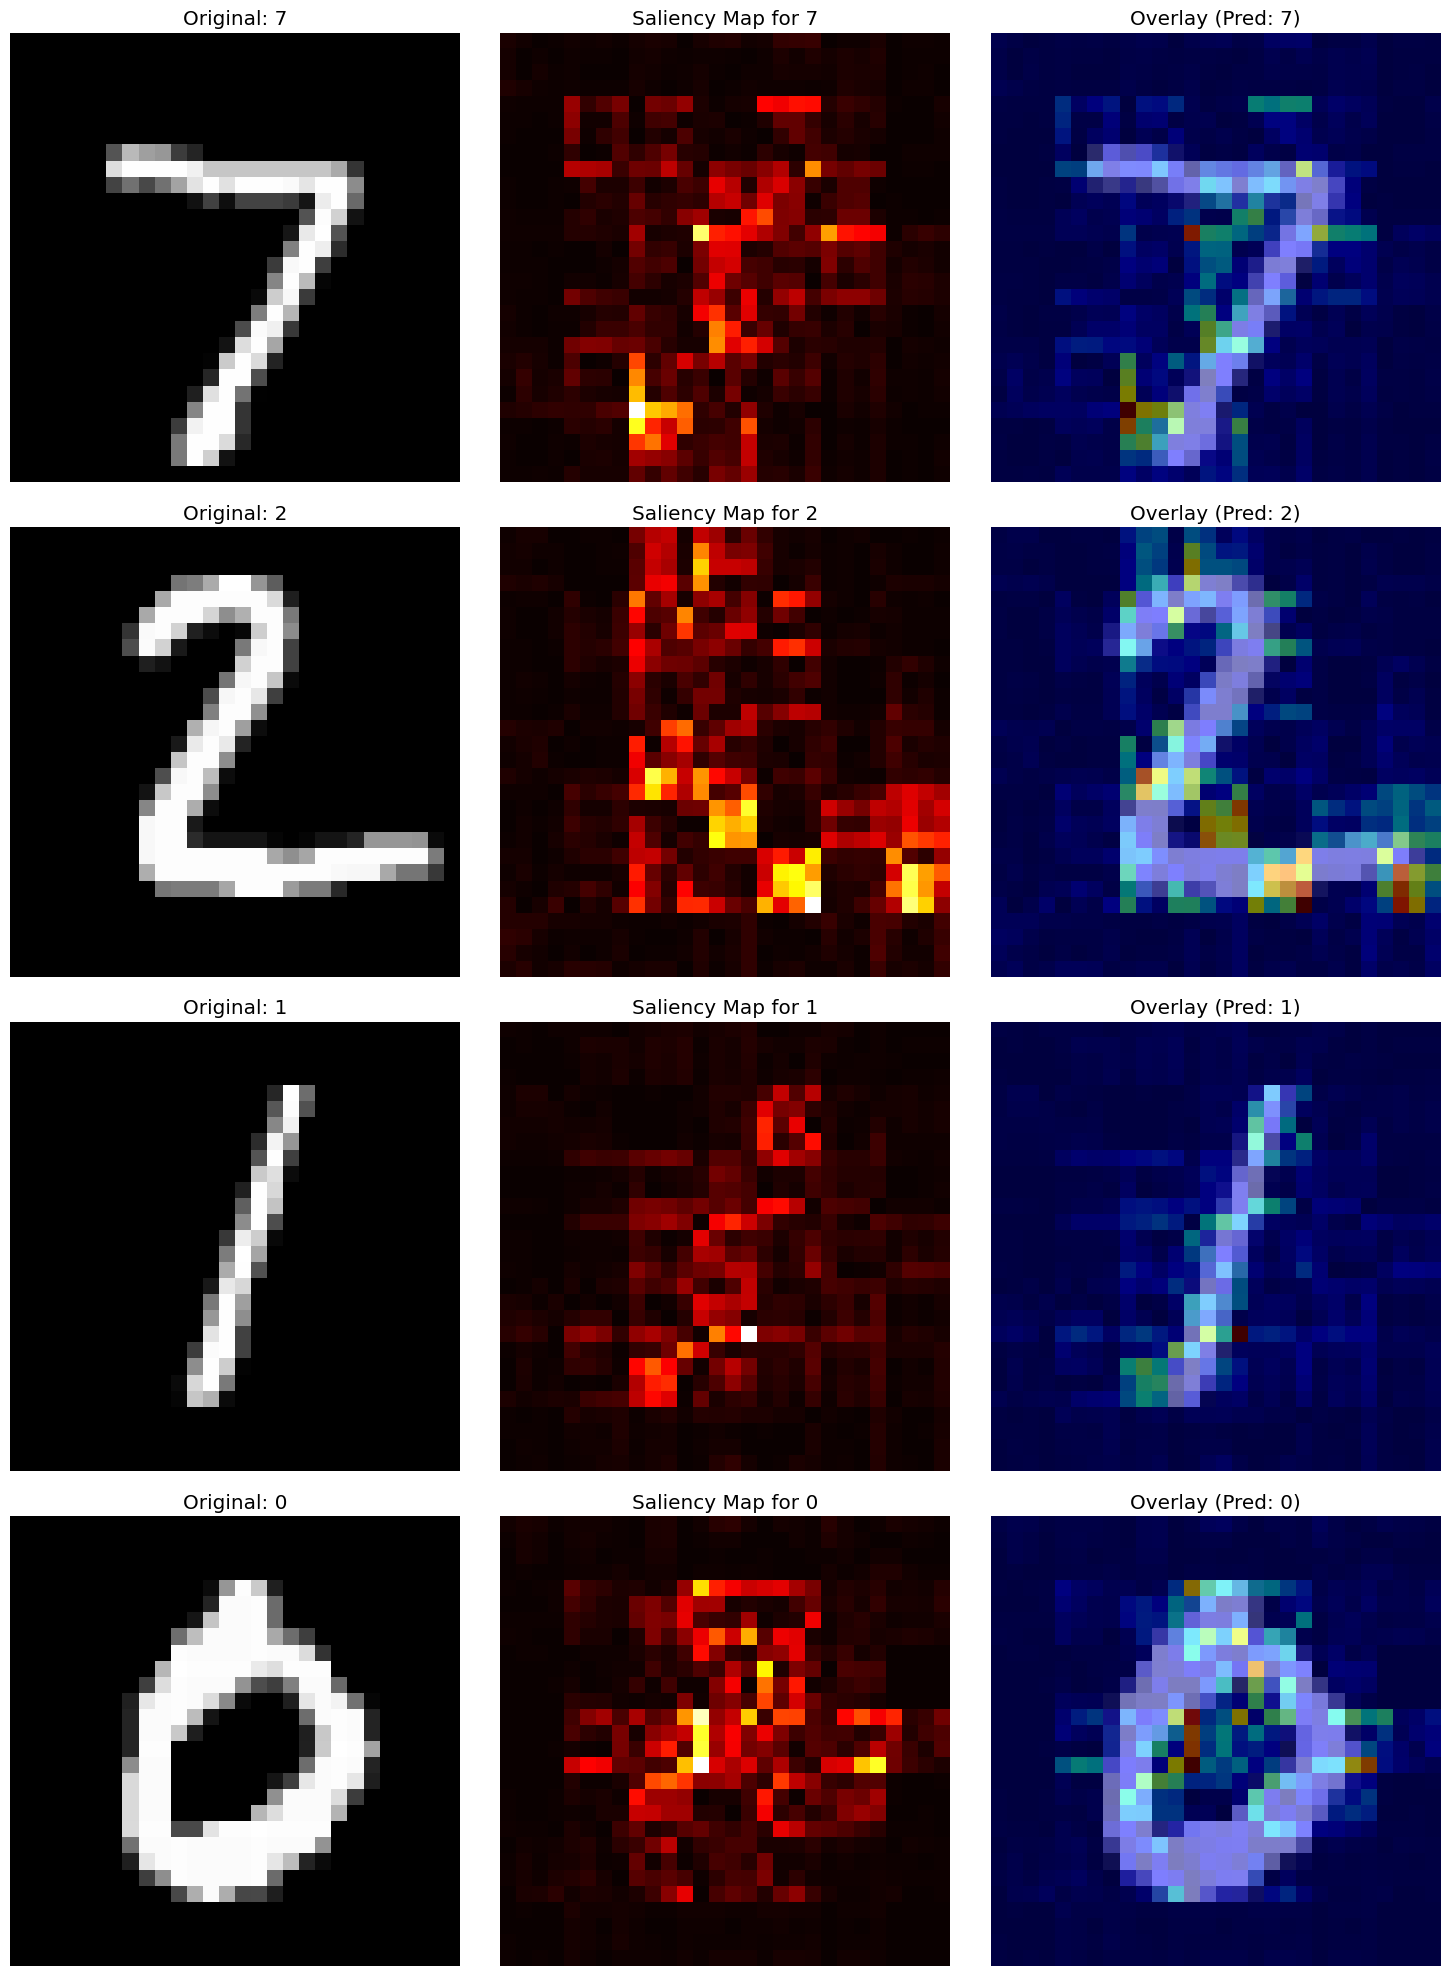

No attention maps found. Check that model.blocks[-1].attn.save_attention is set to True.


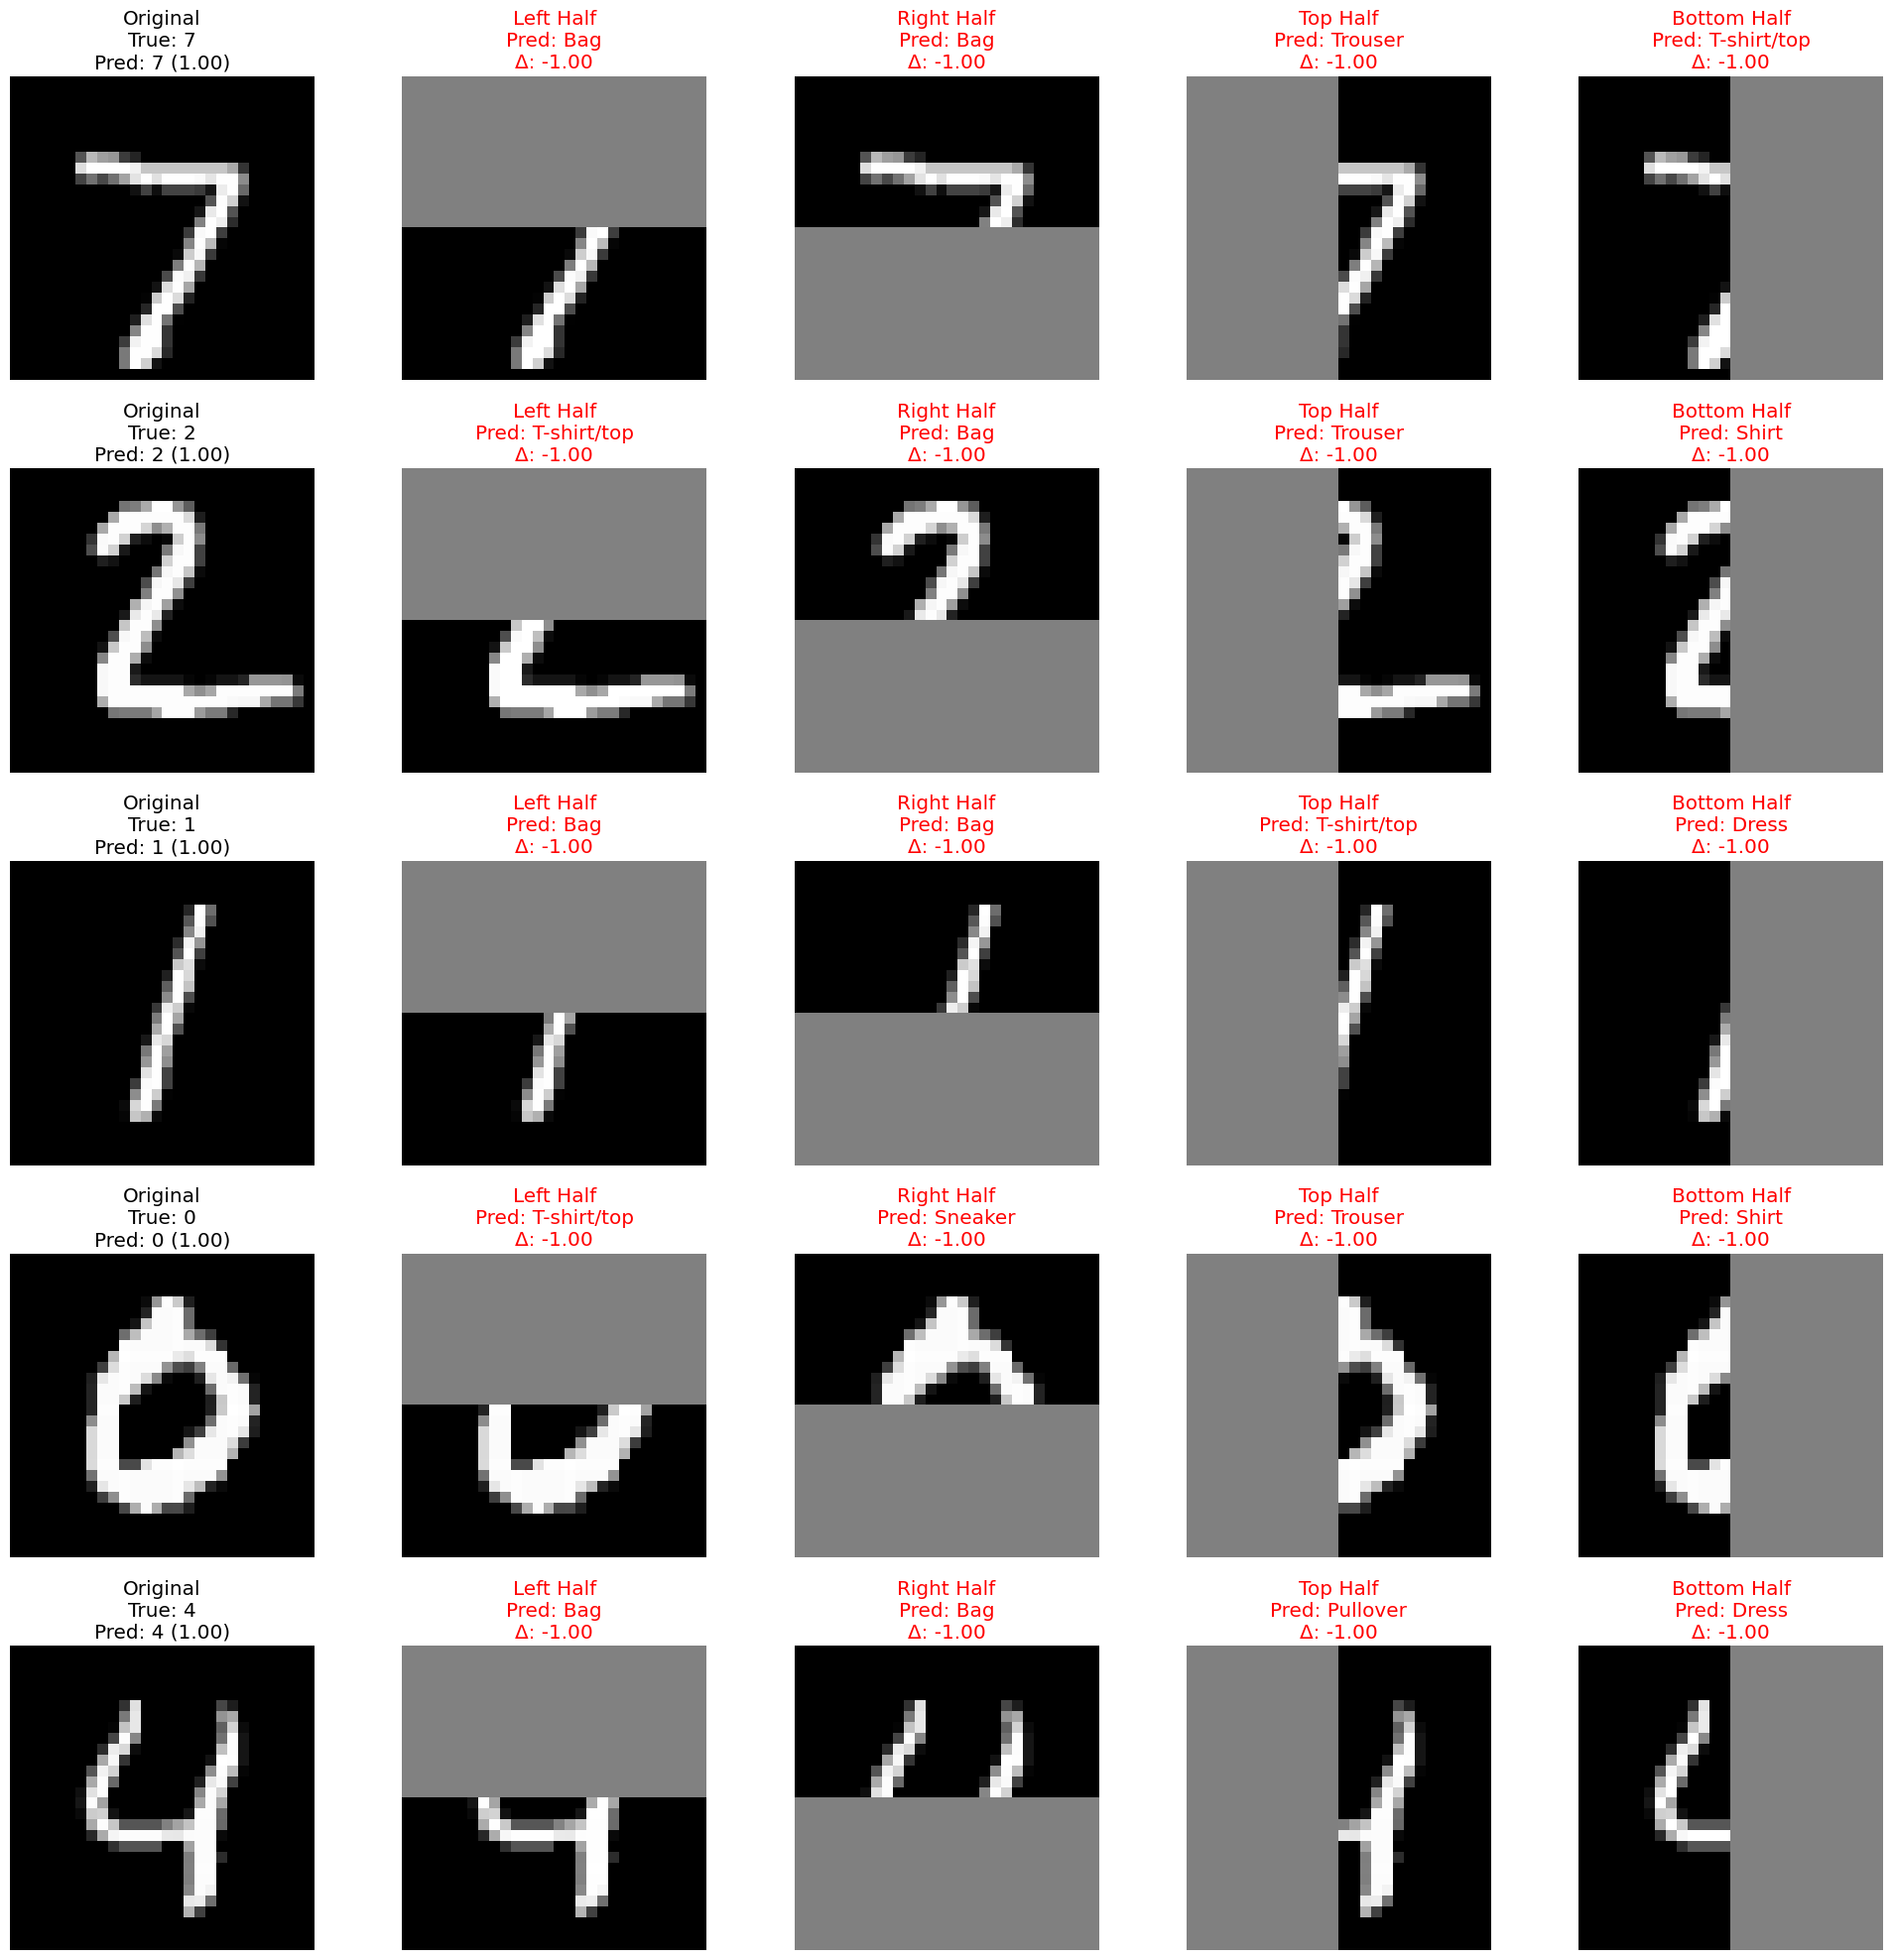

HTML(value='<h2>Interactive Predictions Explorer</h2>')

HTML(value='<p>Use the slider to browse samples, or filter with the buttons below:</p>')

IntSlider(value=0, continuous_update=False, description='Sample:', layout=Layout(width='600px'), max=19)

Output()

In [26]:
# Load the best model
checkpoint_path = os.path.join(save_dir, 'best_model.pt')
checkpoint = torch.load(checkpoint_path, weights_only=False)

model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1} with validation accuracy: {checkpoint['val_accuracy']:.2f}%")

# Get final evaluation metrics
final_metrics = evaluate(model, val_loader, device)

# 1. Visualize learning curves with interactive plots
plot_interactive_metrics(history)

# 2. Visualize per-class performance
# plot_per_class_metrics(final_metrics, class_names)

# 3. Visualize confusion matrix
plot_advanced_confusion_matrix(final_metrics, class_names)

# 4. Visualize t-SNE embeddings
visualize_tsne_embeddings(model, val_loader, class_names)

# 5. Visualize attention maps
visualize_cls_attention(model, val_loader, class_names)

# 6. Visualize saliency maps
visualize_saliency_maps(model, val_loader, class_names)

# 7. Visualize layer activations
# visualize_layer_activations(model, val_loader)

# 8. Visualize attention patterns
visualize_attention_patterns(model, val_loader)

# 9. Analyze feature importance
analyze_feature_importance(model, val_loader, class_names)

# 10. Visualize embedding clusters
# visualize_embedding_clusters(model, val_loader, class_names)

# 11. Interactive predictions explorer
interactive_predictions_explorer(model, val_loader, class_names)